# Recent COVID-19 events have placed an emphasis on "flattening the curve" so that the number of cases does not exceed the capacity to handle those cases

## The purpose of this is to provide a time-series forecast model to predict if the number of positives a country/territory will receive within the next number of days will increase or decrease

# Models used:

> AutoRegressive Integrated Moving Average (ARIMA) used as a baseline and for feature selection, referenced a guide from Jason Brownlee: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

> Multiple classification machine learning algorithms from scikit learn to determine if the number will go up or down

# Initialize some things

In [1]:
import pandas as pd
from datetime import date
from datetime import timedelta
from matplotlib import pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from math import log
from tabulate import tabulate
import time
import pickle
import warnings
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree.export import export_text
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from statistics import stdev as std
from IPython.display import display, clear_output
import random
from sklearn.model_selection import GridSearchCV

In [2]:
class Timer:
    def __init__(self):
        self.start = time.time()
        
    def restart(self):
        self.start = time.time()
        
    def get_new_time(self):
        value = time.time() - self.start
        self.restart()
        return value

In [3]:
days_missing = 2 # Threshold for the maximum consequitive days a country can be missing data to accept data
days_total = 20 # Threshold for the minimum number of days required from a country to accept data
cases_max = 20 # Threshold for maximum number of cases recorded in a day to accept data

run_autocorrelation = False # runs autocorrelation to look at correlated number of lags in time series data

run_ARIMA = False # runs ARIMA to explore data, this takes 2-5 hours but can be parallelized to speed up
outpath_ARIMA = 'ARIMA_results' # path to output pickle file of results from ARIMA test
read_ARIMA_results = True # read ARIMA results from previous runs
input_ARIMA = ['ARIMA_results', 'ARIMA_results_par'] # paths to input pickle files to read results from past ARIMA tests

test_split = .10 # percent to pull out for testing at end
resample = True # Resamples train and test data, if false will read from file otherwise if true will write to file
output_sample = 'MLA_sample'
input_sample = 'MLA_sample'

run_class = True # runs MLA classification tests
output_class = 'MLA_classification_results' # path to otuput pickle file with results from classification MLA tests
read_class_results = False # reads MLA classification results from previous runs
input_class = ['MLA_classification_results'] # paths to input pickle files to read results from past class MLA tests

run_regerss = True # runs MLA regression tests
output_regress = 'MLA_regression_results' # path to otuput pickle file with results from regression MLA tests
read_regress_results = False # reads MLA regression results from previous runs
input_regress = ['MLA_regression_results'] # paths to input pickle files to read results from past class MLA tests

# Method definitions

In [4]:
# read and mungle data with number of cases from covid-19 file from european cdc:
# https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
# keeps the columns ['Date', 'Cases', 'Country']
# changes name of some countries to match population data from the UN:
# https://population.un.org/wpp/Download/Standard/CS
# drops some regions that do not exist in the UN population file
# accepts data from a country if all data have no more number of missing consequitive days than days_missing
# accepts data from a country if all data have a maximum number of total days greater than days_total
# accepts data from a country if all data have a maximum number of cases greater than cases_max
# returns data sorted by ascending date while keeping grouped by country
# rows which did not have an entry for that date have the number of cases set to -1
def readCOVID19(path, days_missing, days_total, cases_max):
    
    covid19_cases = pd.read_csv('COVID-19_cases_20200320.csv')

    # remove all attributes except country and number of cases by date
    covid19_cases = covid19_cases[['DateRep', 'Cases', 'Countries and territories']]
    covid19_cases.columns = ['Date', 'Cases', 'Country']
    covid19_cases['Date'] = pd.to_datetime(covid19_cases.Date)

    # organize by day number
    data = covid19_cases.sort_values(by=['Country','Date'])

    # fix something so the cases an population .csv file names match up by country name
    data['Country'] = data['Country'].str.replace('_', ' ')
    data['Country'] = data['Country'].str.replace('CANADA', 'Canada') # Canada was entered in all-caps?
    data = data.loc[data['Country'] != 'Cote dIvoire']
    data = data.loc[data['Country'] != 'Kosovo']
    data = data.loc[data['Country'] != 'Cases on an international conveyance Japan']
    
    # mungle loop that chooses to accept data based on previous parameters
    # also redoes the 'Date' column to be 'Day' column which is number of days since first outbreak in that country
    reranked = [] # array of new rows to make new dataframe at end
    tosort = {} # dictionary that will sort country data in descending order of max number of cases
    lastCountry = '' # keep track of country in previous row 
    lastDate = '' # keep track of date in previous row
    dayNum = 1 # start with day 1
    firstCase = False # log if this is the first case for given country
    temp = [] # temp array to hold data points from a country, will either be accepted or rejected
    skip = False # control if temp array is accepted or rejected
    maxCases = 0 # keep track of maximum number of cases for country, to sort countries by severity
    maxes = [] # keep track of all max cases for all countries
    for index, row in data.iterrows():
        
        # get column values for this row
        thisDate = row[0]
        cases = row[1]
        country = row[2]

        # check if this is a new country from previous row
        if country not in lastCountry:
            # choose to either accept or reject data from last country
            if not skip and len(temp) >= days_total and maxCases > cases_max:
                tosort[lastCountry] = [temp, maxCases] # save temp array to the tosort dictionary if accepted
                maxes.append(maxCases)  # save list of max cases to array if accepted
            # make a new temp array for this new country's data, and reinitialize other vars
            temp = []
            skip = False
            firstCase = False
            dayNum = 1
            maxCases = 0

        # check if this date is first case for this country
        if cases > 0 and not firstCase:
            lastDate = thisDate
            firstCase = True

        # if we are on or passed our first date, then log data
        if firstCase:
            # get change in days betwen this date and last date
            deltaDays = (thisDate - lastDate).days
            if deltaDays < 0:
                print('Error data is not properly sorted by date', country, thisDate)
            # check if the days inbetween this row and last row exceeds our threshold to accept
            elif not skip and deltaDays > days_missing + 1:
                skip = True
            else:
                # keep track of max vases
                maxCases = max(cases, maxCases)
                # add for each day in between
                for i in range(deltaDays-1):
                    # add data to temp array
                    temp.append([dayNum + i + 1, -1, country, lastDate + timedelta(days=1+i), False])
                # add for this day
                dayNum += deltaDays
                temp.append([dayNum, cases, country, thisDate, True])
                
        # log previous date and country
        lastDate = thisDate
        lastCountry = country
        
    # add values from temp array for last country if we are to accept
    if not skip and len(temp) >= days_total and maxCases > cases_max:
        tosort[lastCountry] = [temp, maxCases]
        maxes.append(maxCases)

    # sort countries now by highest number of cases (mostly for visual purposes of plots)
    while len(maxes) > 0:
        # get next max value
        thisMax = max(maxes)
        # look for countries with max value
        pops = [] # keep track of what country to remove from tosort
        for country in tosort:
            # get values for thsi country
            rows = tosort[country][0]
            maxCases = tosort[country][1]
            # if this has max value then add to final rows
            if thisMax == maxCases:
                reranked = reranked + rows
                pops.append(country) 
        # remove countries that were aded from temporary tosort dict
        for country in pops:        
            tosort.pop(country)
        # remove this max from list of max cases
        maxes = [x for x in maxes if x < thisMax]

    # make new data frame with ranked, mungled data
    data = pd.DataFrame(reranked, columns=['Day', 'Cases', 'Country', 'Date', 'Valid'])
    
    return data

In [5]:
# plots all COVID19 data 5 at a time (5 countries per plot)
# @data is pandas data frame with 3 columns ['Day', 'Cases', 'Country'] 
    # grouped by country, reformated by day# since first outbreak, sorted by ascending day
# @xlabel is x-axis label to output on plots
# @ylabel is y-axis label to output on plots
def plot5(data, xlabel='Day', ylabel='Cases'):
    # redo plot every 5 countries
    lastCut = 0 # get rows to cut for a plot of 5 countries
    lastCountry = data.at[0,'Country'] # keep track of what the last country in the last row was
    while lastCut < len(data) - 1:
        
        # init cut in dataframe to last cut from from plot
        thisCut = lastCut
        
        # iterate through rows and add to this cut until we have reached a 6th
        nCountries = 0 # keep track of how many countries are in current cut
        for i in range(lastCut, len(data), 1):
            # get country this row is frome
            thisCountry = str(data.at[i,'Country'])
            # check if we have added all rows from a new country
            if thisCountry not in lastCountry or i == len(data) - 1:
                nCountries += 1
            # log what country the previous row is from
            lastCountry = thisCountry
            # check if we have 5 countries worth of data in cut
            if nCountries > 4:
                break
            # otherwise increase cut by another row
            thisCut += 1
        
        # plot this cut
        fig, ax = plt.subplots(figsize=(15,7))
        data_temp = data.iloc[lastCut:thisCut]
        data_temp.loc[data_temp['Cases'] > -1].groupby(['Day', 'Country']).sum()['Cases'].unstack().plot(ax=ax)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        # log previous cut
        lastCut = thisCut

In [6]:
# returns Root Mean Squared Error (RMSE) between two lists
def root_mean_squared_error(test, predictions):
    if len(test) == len(predictions):
        error = 0.
        for i in range(len(test)):
            error += (test[i] - predictions[i]) ** 2
        error /= float(len(test))
        return sqrt(error)

# returns Root Mean Squared Percent Error (RMSPE) between two lists
def root_mean_squared_percent_error(test, predictions):
    if len(test) == len(predictions):
        error = 0.
        for i in range(len(test)):
            error += ((test[i] - predictions[i]) / test[i]) ** 2
        error /= float(len(test))
        return 100 * sqrt(error)

In [7]:
# split into dictionary and remove 0s
# data is pandas data frame following structure returned from readCOVID19()
# returns a dictionary that maps country to a list of cases ordered by day number
def data_prep_ARIMA(data):
    # loop through data and create lists by country name
    data_dict = {} # init dictionary
    for i in range(len(data)):
        # get country from row 
        country = data.at[i,'Country']
        # check if country in dictionary
        if country not in data_dict:
            # if not, then intit a new list
            data_dict[country] = []
        # check if cases number from row is positive non-zero
        if data.at[i,'Cases'] > 0:
            # add to list for this country if positive non-zero
            data_dict[country].append(data.at[i,'Cases'])
    return data_dict

In [8]:
# plot autocorrelation for number of lags in time-series
# one plot for each country
# @data_dict is a dictionary mapping countries to list of cases
def autocorrelation_plots(data_dict):
    for country in data_dict:
        autocorrelation_plot(data_dict[country])
        plt.title(country)
        plt.show()

In [9]:
# runs an ARIMA test on data over range of p, d, q
# @data_dict is a dictionary mapping countries to list of cases
# @nDays_range is range of days to check in viewing window
# @derivative_range is range of derivatives to check (0 or 1 make most sense)
# @lag_vals a list of two numbers to add to nDays during iteration:
    # first index is starting value for range
    # second index is ending value for range (non-inclusive)
# @output_ARIMA is path to file to output results as pickle 
# @header is a list of strings for header to table that is output
def iter_ARIMA(data_dict, nDays_range, derivative_range, lag_vals, output_ARIMA, header):
    # initialize some vars
    warnings.filterwarnings('ignore') # ignore warnings that show when datapoints do not converge
    rmspe = {} # log rmspe for each iteration, by country
    rmse = {} # log rmse for each iteration, by country
    params = {} # log parameters, by country
    allTests = {} # log test case values, by country
    allPredictions = {} # log predicted case values, by country
    # init lists that keeps track of all results 
    rmspe['all'] = [] 
    rmse['all'] = []
    params['all'] = []
    allTests['all'] = []
    allPredictions['all'] = []
    table = [] # table for output, previewing live results
    times = [] # list of how long each iteration takes
    timer = Timer() # init timer
    
    # iterate through desired number of days in viewing window
    for nDays in nDays_range:
        # iterate through degree of derivative to take
        for derivative in derivative_range:
            # iterate through number of lags to look at (number of windows to predict next value)
            for lag in range(nDays + lag_vals[0], nDays + lag_vals[1], 1):
                theseTests = [] # temp list logging tests
                thesePredictions = [] # temp list logging predictions
                nConverged = 0 # log number of datapoints which converged
                nTried = 0 # log number of datapoints attempted to converge
                
                # run ARIMA on each country
                for country in data_dict:
                    # get entire time-series of datapoints
                    X = data_dict[country]
                    # check if time-series is long enough
                    if len(X) <= lag:
                        continue
                    # get first index for chunking into train and test values
                    size = 1 + lag + derivative
                    # chunk into train and test
                    train, test = X[0:size], X[size:len(X)]
                    test_conv = [] # keep track of test values which converge
                    history = [x for x in train] # accumalating history of all values in train chunk
                    predictions = [] # keep track of predicted values for those which converge
                    nSuccess = len(test) # list the number of success (subtract when error happens from non-convergence)
                    # test on all datapoints in test chunk
                    for t in range(len(test)):
                        nTried += 1 # inc data point tried
                        # try to fit ARIMA, error will throw if not converged
                        try:
                            # get current history
                            hist_temp = history
                            # add to future history
                            history.append(test[t])
                            # make ARIMA model
                            model = ARIMA(hist_temp, order=(lag, derivative, nDays))
                            # fit ARIMA model
                            model_fit = model.fit(maxiter=1000)
                            # predict next value in test chunk
                            output = model_fit.forecast()
                            # if we are here than converged, add to success lists
                            test_conv.append(test[t])
                            predictions.append(output[0])
                        # if an error is thrown dec the number of successes
                        except Exception as e:
                            nSuccess -= 1
                    # if atleast one data point converged then log results for this country
                    if nSuccess > 0:
                        nConverged += nSuccess # inc number converged
                        theseTests = theseTests + test_conv # add to test list
                        thesePredictions = thesePredictions + predictions # add to prediction list
                        error1 = root_mean_squared_error(test_conv, predictions) # calc rmse
                        error2 = root_mean_squared_percent_error(test_conv, predictions) # calc rmspe
                        # check if we need to init a list for this country in results dict
                        if country not in rmse:
                            rmse[country] = []
                            rmspe[country] = []
                            params[country] = []
                            allTests[country] = []
                            allPredictions[country] = []
                        # add results to respective dict for this country
                        rmse[country].append(error1)
                        rmspe[country].append(error2)
                        params[country].append([lag,derivative,nDays])
                        allTests[country].append(test_conv)
                        allPredictions[country].append(predictions)

                # log results for all countries
                this_time = timer.get_new_time() # check timer
                times.append(this_time) # add time for iteration
                # check if any datapoints converged for this iteration then add to results
                if nConverged > 0:
                    error1 = root_mean_squared_error(theseTests, thesePredictions) # calc rmse for all countries
                    error2 = root_mean_squared_percent_error(theseTests, thesePredictions) # same for rmspe
                    params['all'].append([lag, derivative, nDays]) # add parameters checked this iter
                    allTests['all'].append(theseTests) # add all test datapoints to list 
                    allPredictions['all'].append(thesePredictions) # add all predictions to list
                    rmse['all'].append(error1) # add rmse
                    rmspe['all'].append(error2) # add rmspe
                    table.append([ lag, derivative, nDays, round(error2, 2), round(error1, 2)
                                  , round(100 * nConverged / nTried, 2), this_time ]) # add new row with results to table
                    clear_output() # clear output on screen for new table
                    print(tabulate(table, headers=header)) # print new table
    
    # write pickle file for easy reading later
    ARIMA_results = [rmspe, rmse, params, allTests, allPredictions, table]
    with open(output_ARIMA, 'wb') as outfile:
        pickle.dump(ARIMA_results, outfile)
        
    return ARIMA_results

In [10]:
# reads and displays arima output from previous runs
# @input_ARIMA list of paths to files to read pervious results from
# @header list of strings that are header to table
def read_ARIMA(input_ARIMA, header):
    ARIMA_results = {}
    for arima in input_ARIMA:
        with open(arima, 'rb' ) as infile:
            ARIMA_results[arima] = pickle.load(infile)
            print(tabulate(ARIMA_results[arima][-1], headers=header))
    return ARIMA_results

In [11]:
# takes the moving sum of data
# @data is pandas data frame split by ('Day', 'Cases', 'Country') 
    # assumed to be grouped by country name and sorted by day number in ascending order
# @days_moving is window size of moving sum
# returns dataFrame similar to @data except days are moving sums of those days 
    # there will be days_moving-1 less rows for each country
def moving_sum(data, days_moving):
    # take moving sum
    newRows = [] # keep track of new rows to make new data frame at end
    lastCountry = '' # keep track of country of last row, tells when to reset moving window
    counter = 0 # count number of rows viewed from country
    idx = 0 # track index of moving window
    window = [None] * days_moving # init moving window
    for i in range(len(data)):
        # get country of this row
        country = str(data.at[i, 'Country'])
        # check if this is the next country
        if country not in lastCountry:
            # if so then reset counter
            counter = 0
        # set value at current window location
        window[idx] = max(0, data.at[i, 'Cases'])
        # increment revovling window
        idx += 1
        if idx >= days_moving:
            idx = 0
        # inc number of datapoints in this country
        counter += 1
        # if enough datapoints, then add to newRows array to later build dataframe
        if counter >= days_moving:
            newRows.append([data.at[i, 'Day'], sum(window), country, data.at[i, 'Date'], data.at[i, 'Cases'] >= 0])
        # log country of last row
        lastCountry = country
        
    # create new dataframe from moving window rows
    data2 = pd.DataFrame(newRows, columns=['Day', 'Cases', 'Country', 'Date', 'Valid'])
    return data2

In [12]:
# creates X and Y datapoints, for train and test sets
# @data is a dataframe following the architecture from read_COVID19()
# @window_size is size of moving sum
# @lags is number of previous datapoints to put into X
# @outputs is number of following datapoints after X to put into Y
# @output_sample is path to file to write out pickle of return object
# @start_date is optional start_date of label to log data
# @label_type determines how to set Y, it is either:
    # 'next' for count after X (DEFAULT)
    # 'change' for the difference of count after X
    # 'class' for either binary 0 for a decrease after X or 1 for increase
# @test_split is optional value between [0,1] to decide the percent of test split
# return data, Xs, Ys, countries, days all mapped by either 'train' or 'test' in one dict
def prepare_MLA(data, window_size, lags, outputs, output_sample, label_type='next', test_split=0):
    
    # set params list
    params = {'window_size' : window_size, 'lags' : lags, 'outputs' : outputs
              , 'label_type' : label_type}
        
    # calculate moving sum of data
    if window_size > 1:
        data = moving_sum(data, window_size)
    
    # create empty matricies to be filled with data chunks
    Xs = {'train' : [], 'test' : []} # feature vectors
    Ys = {'train' : [], 'test' : []} # labels
    countries = {'train' : [], 'test' : []} # country names
    days = {'train' : [], 'test' : []} # day numbers of label

    # move through all rows in data
    for i in range(len(data)):

        # check for out of bounds 
        if i + lags + outputs > len(data):
            break
            
        # get country for this row
        country = str(data.at[i, 'Country'])
        
        # check if enough consequetive values are from same country
        if data.at[i + lags + outputs - 1, 'Country'] not in country:
            continue
        
        # check if all data points are valid
        skip = False
        
        # add lags to featuer vector to make a new chunk
        x = []
        for j in range(i, i + lags, 1):
            if not data.at[j, 'Valid']:
                skip = True
            x.append(data.at[j, 'Cases'])

        # get labels for number of outputs
        y = []
        day = [] # get day(s) of label
        for j in range(i + lags, i + lags + outputs, 1):
            if not data.at[j, 'Valid']:
                skip = True
            if label_type in 'next':
                y.append(int(data.at[j, 'Cases']))
            elif label_type in 'change':
                y.append(int(data.at[j, 'Cases']) - int(data.at[j - 1, 'Cases']))
            elif label_type in 'class':
                y.append(1 if int(data.at[j, 'Cases']) > int(data.at[j - 1, 'Cases']) else 0)
            day.append(int(data.at[j, 'Day']))
        if skip:
            continue
        
        # check if we add to train or test set
        addto = 'train'
        if random.random() < test_split:
            addto = 'test'
        
        # add chunk to matrices
        Xs[addto].append(x)
        if len(y) > 1:
            Ys[addto].append(y)
        else:
            Ys[addto].append(y[0])
        countries[addto].append(country)
        days[addto].append(day)
        
    #write pickle file
    pickle_out = {'data' : data, 'Xs' : Xs, 'Ys' : Ys, 'countries' : countries, 'days' : days, 'params' : params}
    with open(output_sample, 'wb') as outfile:
        pickle.dump(pickle_out, outfile)
        
    return pickle_out

In [13]:
# reads pickle files of premade samples used MLA
# @input_sample is list of file paths to pickle files
# @returns list of samples
def read_samples(input_sample):
    samples = []
    for pickle_file in input_sample:
        with open(pickle_file, 'rb' ) as infile:
            samples.append(pickle.load(infile))
    return samples

In [14]:
def crossValidation_class(name, X, y, nIters, nFolds, layers):
    dis = display(f'running MLA {name}',display_id=True)
    
    # create dummy Machine Learning Algorithm (MLA) object
    mla = tree.DecisionTreeClassifier()
    
    # keep track of results
    means = [None] * nIters
    #stds = [None] * nIters
    
    # get results
    for i in range(nIters):
         # create MLA with new random seed
        if 'DT' in name:
            mla = DecisionTreeClassifier(random_state = i)
        elif 'NB' in name:
            mla = GaussianNB()
        elif 'RF' in name:
            mla = RandomForestClassifier(random_state = i, n_estimators=100)
        elif 'ET' in name:
            mla = ExtraTreesClassifier(random_state = i, n_estimators=100)
        elif 'SV' in name:
            mla = SVC(random_state = i, gamma='auto', probability=True)
        elif 'KN' in name:
            mla = KNeighborsClassifier(n_neighbors=2)
        elif 'ML' in name:
            mla = MLPClassifier(random_state = i, hidden_layer_sizes=layers, max_iter=10000)
            
        scores = cross_val_score(mla, X, y, cv=nFolds)
        means[i] = scores.mean()
        #stds[i] = std(scores)
        dis.update(f'iteration {i+1} of {nIters} done')
    dis.update(f'Average classification accuracy = {100. * sum(means) / len(means):.2f}%')
        
    return means

In [15]:
def plotResults_class(results, mlas, model):
    x_labels = []
    for mla in mlas:
        x_labels.append(mla)
        x_labels.append(' ')
        x_labels.append(' ')
        x_labels.append(' ')
    x_nums = [x for x in range(5*len(mlas))]
    fig = plt.figure(figsize=(7.5,5))
    plt.xticks(x_nums, x_labels, rotation='vertical', fontsize=20)
    plt.yticks([x for x in range(75, 101, 5)], fontsize=20)
    plt.tick_params(axis='x', length=0)
    plt.ylabel('% Classification Accuracy', fontsize=20)
    plt.title('10-Fold Cross-Validation Incrase or Decrease in Cases - Model ' + model, fontsize=20)
    plt.grid(axis='y', linewidth=0.4)
    plt.ylim([75, 101])
    offset = 0
    for mla in results:
        x = [offset for _ in range(len(results[mla]))]
        y = 100. * np.array(results[mla])
        if int(max(y)) <= 75:
            plt.scatter(offset+0, 76, color='green', marker='v')
        else:
            plt.scatter(x, y, color='green', marker='_', s=1000)
        plt.axvline(x=offset, color='grey', linewidth=0.3, alpha=0.3)
        offset += 4
    fig.text(0, -.20, 'Illustrates distribution of accuracies for each MLA.\nResults from 100 random runs.\nA down facing triangle indicates results below 75% accuracy'
             , fontsize=20)

# Read, Mungle, and Plot Data

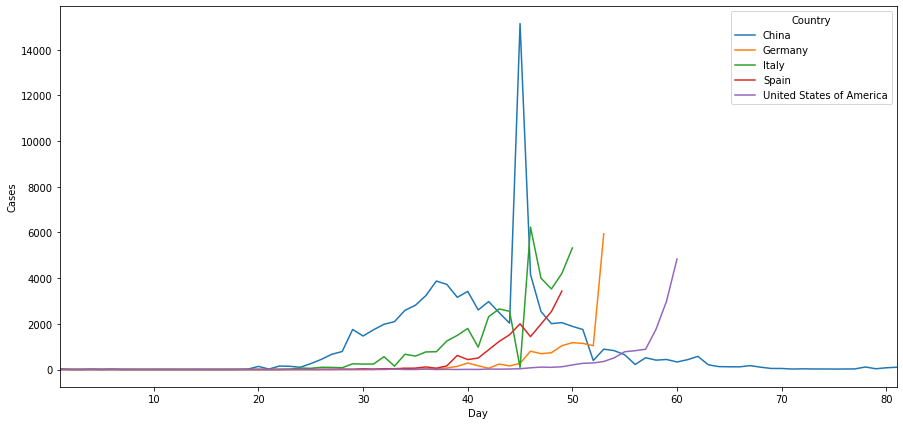

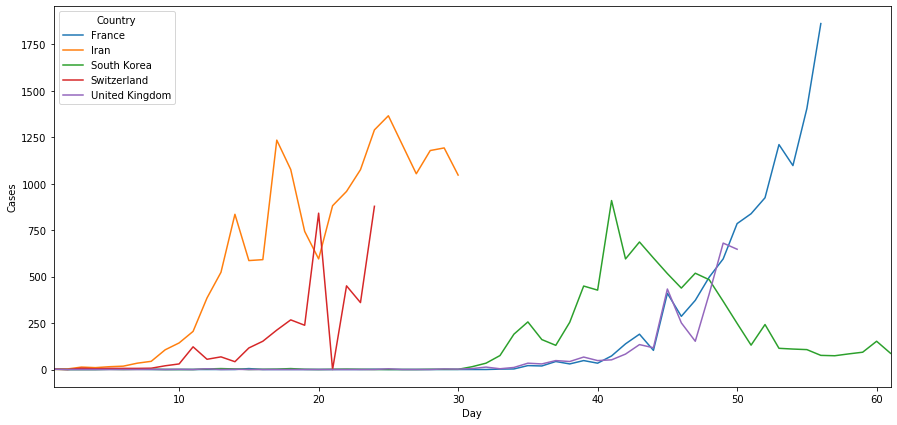

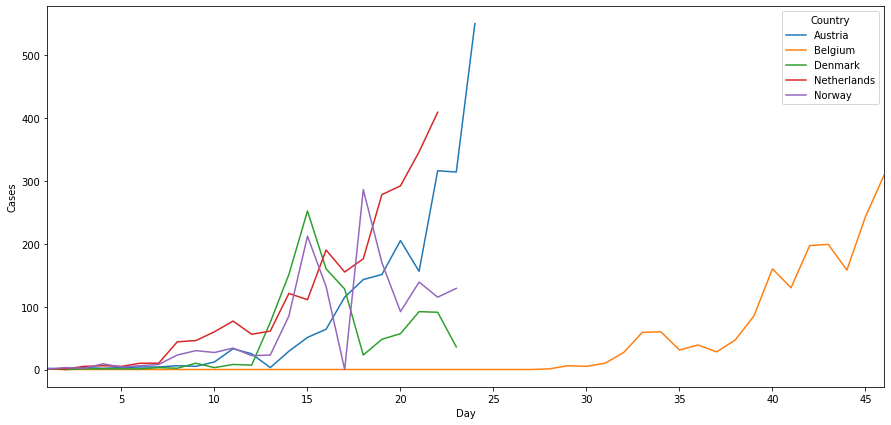

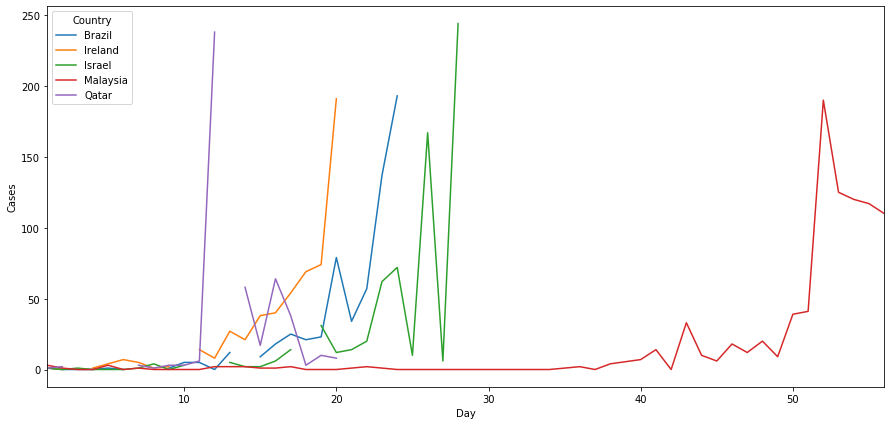

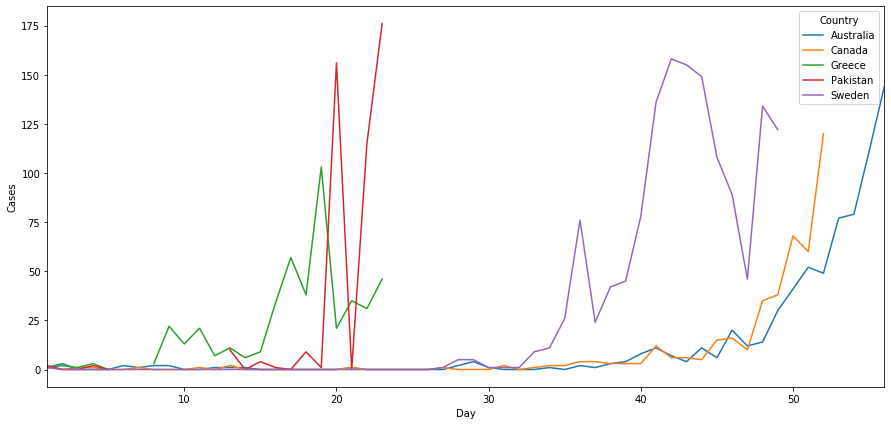

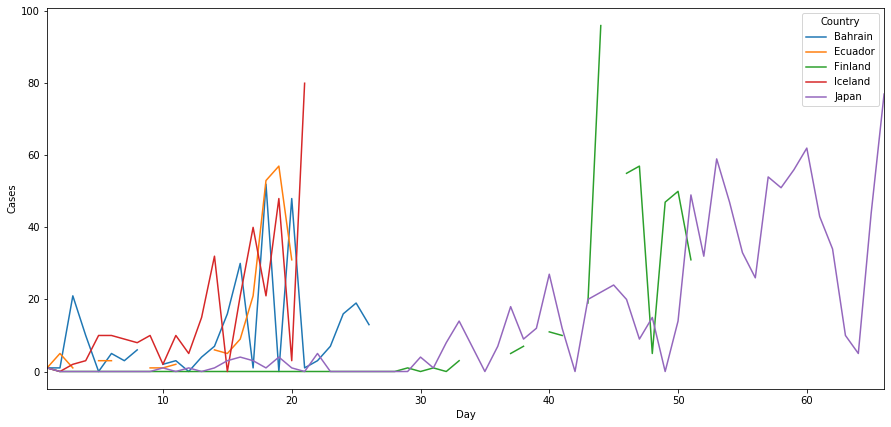

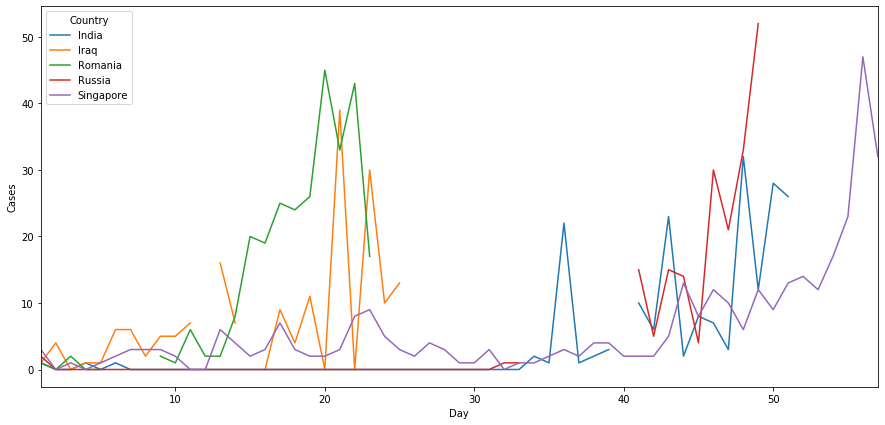

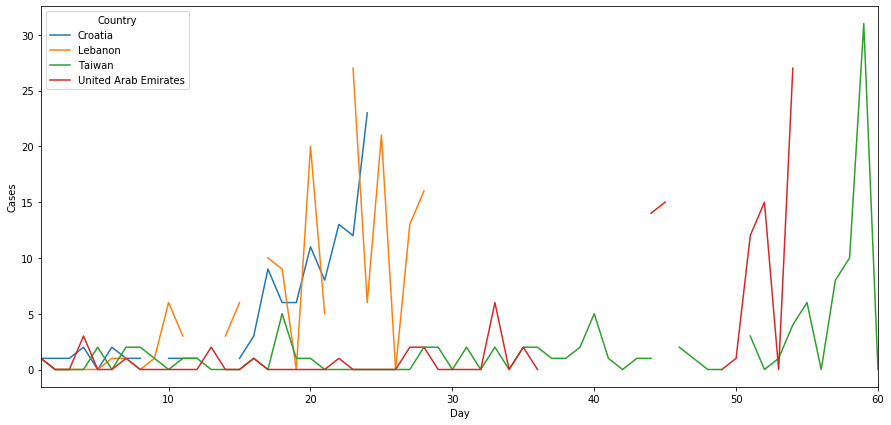

In [16]:
data = readCOVID19('COVID-19_cases_20200320.csv', days_missing, days_total, cases_max)
plot5(data)

# FEATURE SELECTION

In [17]:
# prepare data for ARIMA and autocorrelation
data_dict = data_prep_ARIMA(data)

# run autocorrelation to see good numbers of lags to use
if run_autocorrelation:
    autocorrelation_plots(data_dict)

#### looks like between ~(1-10) lags are correlated (some countries can use more, most around 5)
#### lets use ARIMA to get a baseline, an idea of how many lags should be used, any derivatives, and size of moving average

In [18]:
# header to display ARIMA tables
header = ['Lags', 'Derv', 'Days', 'RMSE %', 'RMSE', '% Converged', 'Exec Time (s)']

# ARIMA testing over a range of lags, derivatives, and moving average days
if run_ARIMA:
    iter_ARIMA(data_dict, range(0, 8, 1), range(1, 2, 1), [1, 8], output_ARIMA, header)
    
# read pickle files (from previous ran ARIMAs) and display tables
if read_ARIMA_results:
    ARIMA_results = read_ARIMA(input_ARIMA, header)

  Lags    Derv    Days    RMSE %      RMSE    % Converged    Exec Time (s)
------  ------  ------  --------  --------  -------------  ---------------
     1       0       0    310.89    212.1           97.39          41.6357
     2       0       0    259.17    592.11          91.27          83.7639
     3       0       0    270.63    405.47          81.3          137.791
     4       0       0    259.55   1303.2           61.14         162.8
     5       0       0    267.84    593.19          49.68         231.219
     6       0       0    262.77    985.45          38.56         276.92
     7       0       0    327.78   1015.42          29.7          436.478
     2       0       1  20135.7    7857.26          25.62          39.1062
     3       0       1    299.75    981.6           20.59          48.201
     4       0       1    302.97    620.75          21.04          75.3245
     5       0       1    321.75   1126.41          19.33         100.52
     6       0       1    373.69    

#### From the two tables, I chose the models which have the best RMSE and convergence, and one with a good balance betwen both
#### A) 12 lags, 1 derivative, 6 day moving window >>>> 34.91% RMSE, 3 cases RMSE, 1.05% datapoints convergence
#### B) 1 lag, 1 derivative, 0 day moving window >>>> 172.23% RMSE, 591 cases RMSE, 98.53% datapoints convergence 
#### C) 4 lag, 0 derivative, 2 day moving window >>>> 75.66% RMSE, 73 cases RMSE, 10.89% datapoitns convergence

# Prepare Data for Machine Learning

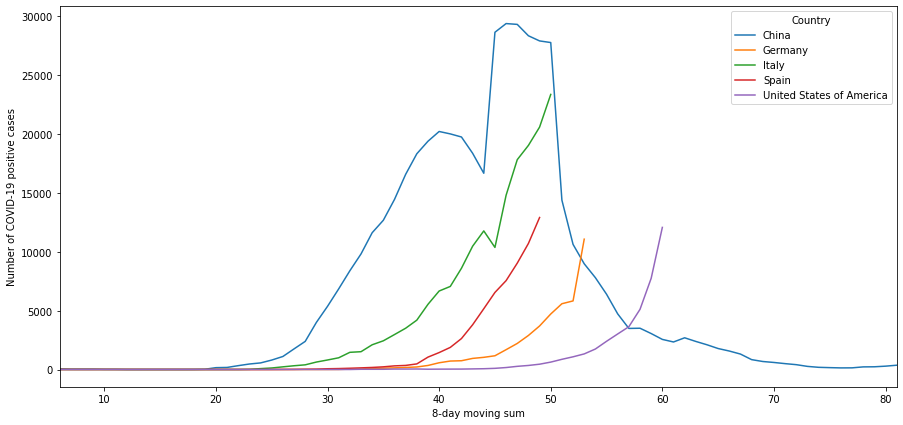

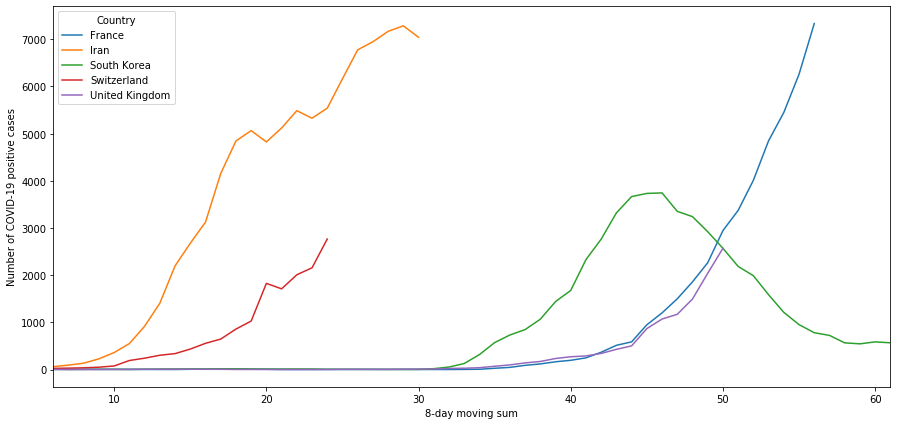

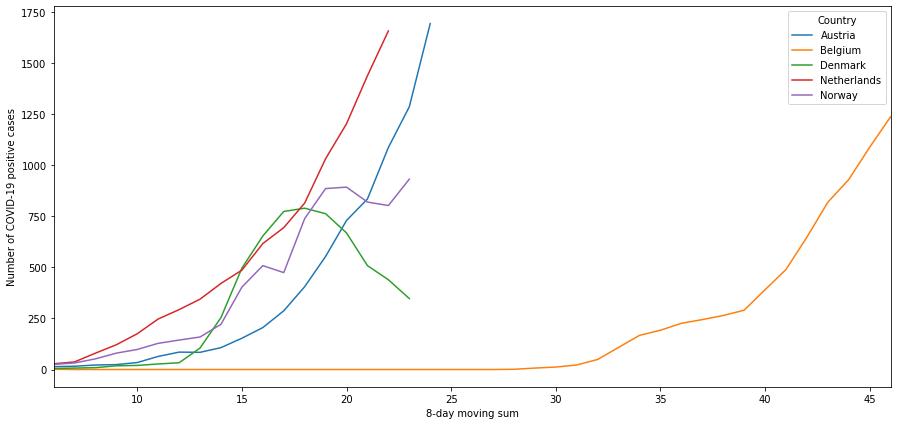

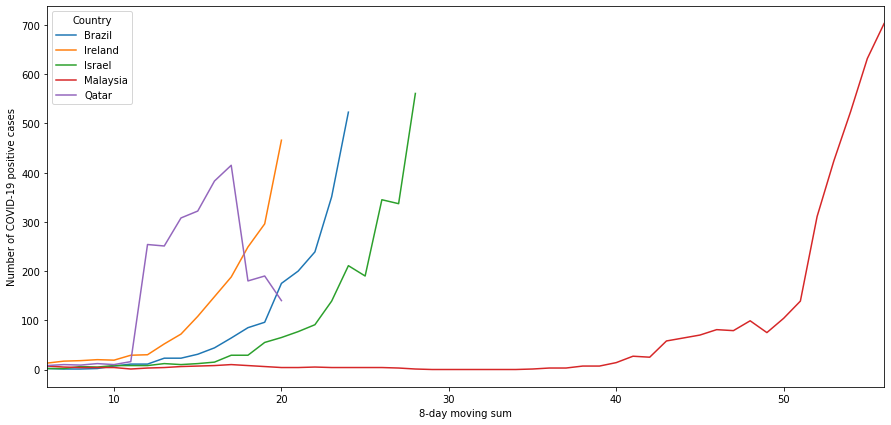

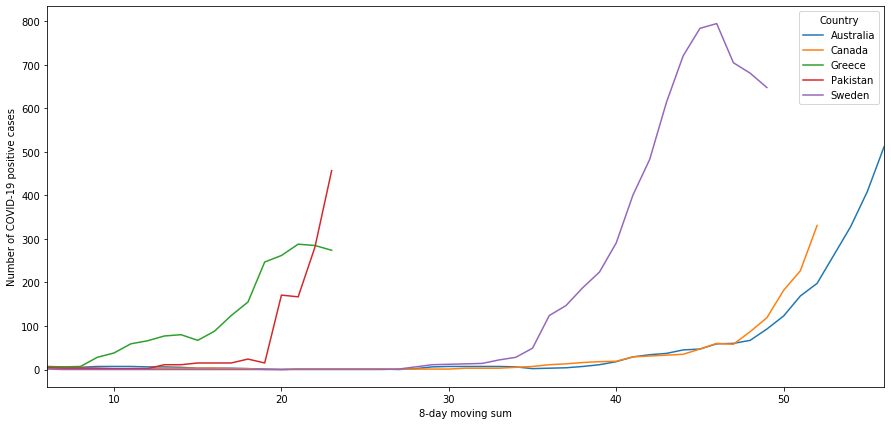

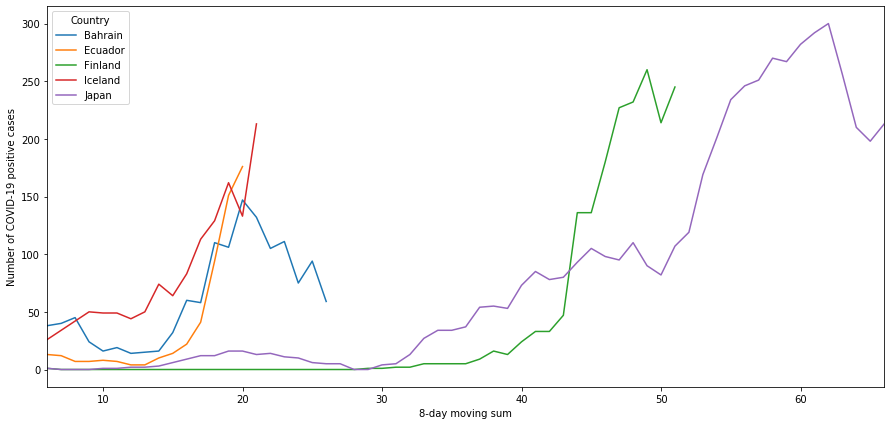

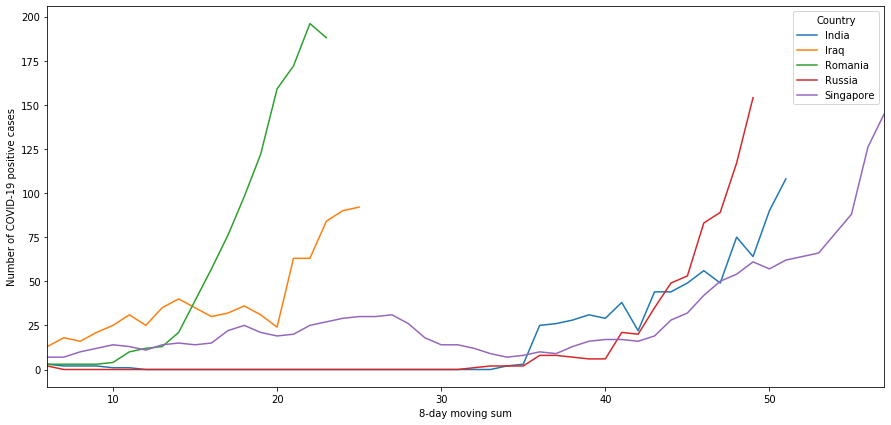

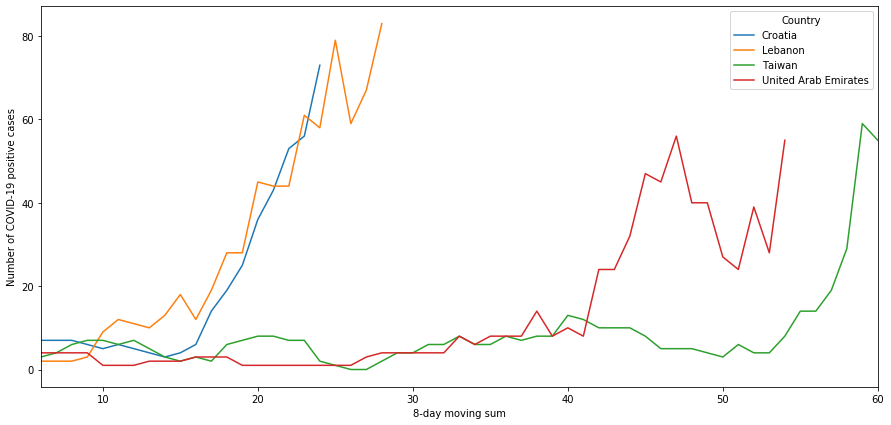

In [19]:
# resample data
samples = []
if resample:
    samples.append(prepare_MLA(data, 6, 12, 1, output_sample + '1', label_type='class', test_split=0))
    samples.append(prepare_MLA(data, 1, 1, 1, output_sample + '2', label_type='class', test_split=0.1))
    samples.append(prepare_MLA(data, 2, 4, 1, output_sample + '3', label_type='class', test_split=0.1))

# read data from pickle file
else:    
    samples = read_samples(input_sample)
    
# view the 8-day moving window (looks much much smoother now)
plot5(samples[0]['data'], '8-day moving sum', 'Number of COVID-19 positive cases')

# Cross-validate for model selection

In [20]:
print(len(samples[0]['Xs']['train']))
print(len(samples[0]['Ys']['train']))
print(len(samples[0]['Xs']['test']))
print(len(samples[0]['Ys']['test']))

#for idx, row in enumerate(samples[0]['Xs']['train']):
   # print(samples[0]['countries']['train'][idx], samples[0]['days']['train'][idx]
        #  ,samples[0]['Xs']['train'][idx], samples[0]['Ys']['train'][idx])

734
734
0
0
China [18] [59, 32, 32, 32, 15, 15, 0, 0, 0, 0, 0, 0] 1
China [19] [32, 32, 32, 15, 15, 0, 0, 0, 0, 0, 0, 4] 1
China [20] [32, 32, 15, 15, 0, 0, 0, 0, 0, 0, 4, 21] 1
China [21] [32, 15, 15, 0, 0, 0, 0, 0, 0, 4, 21, 157] 1
China [22] [15, 15, 0, 0, 0, 0, 0, 0, 4, 21, 157, 176] 1
China [23] [15, 0, 0, 0, 0, 0, 0, 4, 21, 157, 176, 327] 1
China [24] [0, 0, 0, 0, 0, 0, 4, 21, 157, 176, 327, 467] 1
China [25] [0, 0, 0, 0, 0, 4, 21, 157, 176, 327, 467, 560] 1
China [26] [0, 0, 0, 0, 4, 21, 157, 176, 327, 467, 560, 802] 1
China [27] [0, 0, 0, 4, 21, 157, 176, 327, 467, 560, 802, 1107] 1
China [28] [0, 0, 4, 21, 157, 176, 327, 467, 560, 802, 1107, 1753] 1
China [29] [0, 4, 21, 157, 176, 327, 467, 560, 802, 1107, 1753, 2389] 1
China [30] [4, 21, 157, 176, 327, 467, 560, 802, 1107, 1753, 2389, 4002] 1
China [31] [21, 157, 176, 327, 467, 560, 802, 1107, 1753, 2389, 4002, 5371] 1
China [32] [157, 176, 327, 467, 560, 802, 1107, 1753, 2389, 4002, 5371, 6852] 1
China [33] [176, 327, 467, 5

sample 0 ...
MLA ML ...


'Average classification accuracy = 72.44%'

MLA DT ...


'Average classification accuracy = 69.73%'

MLA RF ...


'Average classification accuracy = 75.85%'

MLA ET ...


'Average classification accuracy = 74.34%'

MLA NB ...


'Average classification accuracy = 58.99%'

MLA SV ...


'Average classification accuracy = 69.07%'

MLA KN ...


'Average classification accuracy = 72.04%'

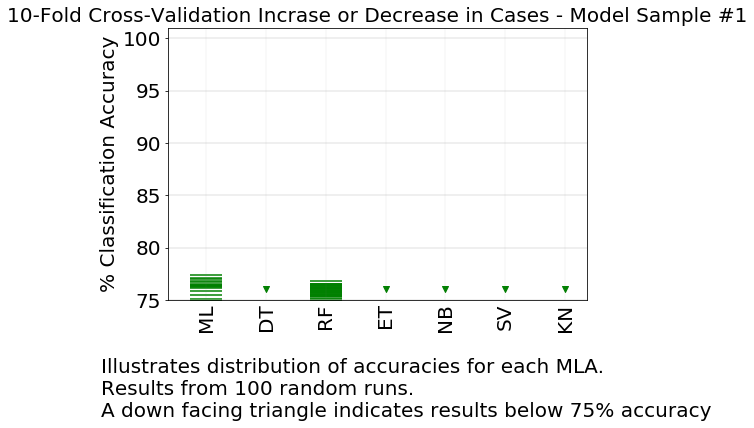

In [21]:
# run classification results of checking if number of cases increases or decreases
class_results = []
mlas = ['ML', 'DT', 'RF', 'ET', 'NB', 'SV', 'KN']
if run_class:
    warnings.filterwarnings('ignore') # ignore warnings that show when models do not converge
    for idx, sample in enumerate(samples):
        results = {}
        print('sample ' + str(idx) + ' ...')
        for mla in mlas:
            print('MLA ' + mla + ' ...')
            results[mla] = crossValidation_class(mla, sample['Xs']['train'], sample['Ys']['train'], 50, 5
                                                 , (max(int((sample['params']['lags'])/2), 1)) )
        class_results.append(results)
        
        #write pickle file with results
        with open(output_class + str(idx + 1), 'wb') as outfile:
            pickle.dump(results, outfile)
        
# plot results
class_results_read = []
if read_class_results:
    for file in input_class:
        with open(file, 'rb' ) as infile:
            class_results_read.append(pickle.load(infile))
            for idx, results in enumerate(class_results_read):
                plotResults_class(results, mlas, 'Sample #' + str(idx + 1)) 
else:
    for idx, results in enumerate(class_results):
        plotResults_class(results, mlas, 'Sample #' + str(idx + 1)) 

In [22]:
# It is very clear from the above plots that model A is the most robust
    # Model A = 12 lags, 1 derivative, 6 day moving window
# The most robust MLA's were Decision Trees, Random Forests, Extra Trees, and Support Vector Machines
# I chose an SVM since they are indepedendent of randomness and performed on-par to the average classification of trees

# Machine Learning Algorithm Optimization

In [23]:
# So our final selection is Model A with an SVM
# the task left is to optimize the parameters of the SVM using a grid search and cross-validation

In [ ]:
# optimize SVM params
warnings.filterwarnings('ignore')
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'C':[1, 10, 100, 1000]
              , 'tol':[0.1, 0.01, 0.001, 0.0001], 'shrinking':[True, False]
             ,'coef0':[0,1,2,3], 'gamma' : ['auto', 'scale']}
svc = SVC(probability=True)
clf = GridSearchCV(svc, parameters)
clf.fit(samples[0]['Xs']['train'], samples[0]['Ys']['train'])
cv_results = clf.cv_results_['mean_test_score']
cv_params = clf.cv_results_['params']
max_acc = max(cv_results)
opt_results = []
opt_params = []
for i in range(len(cv_results)):
    if abs(cv_results[i]-max_acc) <= 0.01:
        opt_results.append(cv_results[i])
        opt_params.append(cv_params[i])
print('optimizied classification accuracy =', max_acc)
print('These parameters obtained optimized acc:')
for params in opt_params:
    print(params)

In [ ]:
# kernel 'rbf' is the most robust, gamma 'auto' is the most robust, C 10-1000 are equally robust 
# coef0 makes no difference, shrkining makes no difference, tol makes no difference
# thus the final svm used kernel 'rbg', gamma 'auto', C 10, and default values for the rest
svc = SVC(kernel='rbf', gamma='auto', C=10, probability=True)

# now we train svs on data and test on the test data
svc.fit(samples[0]['Xs']['train'], samples[0]['Ys']['train'])
test_class = svc.predict(samples[0]['Xs']['test'])
print(f'final test accuracy is:', round(100. * accuracy_score(test_class, samples[0]['Ys']['test']), 2), '%')